# Mushrooms classifier

For this project, I have built a convolutional neural network to classify mushroom species from the [Common genus's images Kaggle dataset](https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images). The network is based on a pretained [ResNet50](https://www.mathworks.com/help/deeplearning/ref/resnet50.html) network, finetuned with [fast.ai v2](https://www.fast.ai/2020/08/21/fastai2-launch/).

## Imports

In [1]:
import fastai
from fastai.vision.all import *
import tqdm

RANDOM_STATE = 42

set_seed(RANDOM_STATE)

In [2]:
# Automatic formatting with black
%load_ext nb_black

<IPython.core.display.Javascript object>

## Helper functions

In [3]:
import pickle


def save_model(model: fastai.learner.Learner, name: str) -> None:
    """
    Save fastai model to a file

    Args:
        model (fastai.learner.Learner): Model to be saved
        name (str): Name for model file
    """
    with open(f"models/{name}.pkl", "wb") as f:
        pickle.dump(model, f)


def load_saved_model(name: str) -> fastai.learner.Learner:
    """
    Load fastai model from a file

    Args:
        name (str): Name of model file

    Returns:
        fastai.learner.Learner: Model loaded from file
    """
    with open(f"models/{name}.pkl", "rb") as f:
        return pickle.load(f)

<IPython.core.display.Javascript object>

## EDA

### Initial look at the data

Let us begin by analysing the mushroom images. Since the different classes are divided by folders, we can get the class names just by listing the directories in the Mushrooms folder

In [13]:
import os

print(os.listdir("Mushrooms"))

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


<IPython.core.display.Javascript object>

As we can see, there are 9 different mushrooms classes. Next, I will count the samples per class

In [160]:
samples_per_specie = {}

for species in os.listdir("Mushrooms"):
    samples = 0
    for sample in os.listdir(f"Mushrooms/{species}"):
        samples += 1
    samples_per_specie[species] = samples

samples_per_specie

{'Agaricus': 353,
 'Amanita': 750,
 'Boletus': 1073,
 'Cortinarius': 836,
 'Entoloma': 364,
 'Hygrocybe': 316,
 'Lactarius': 1563,
 'Russula': 1148,
 'Suillus': 311}

<IPython.core.display.Javascript object>

Now that we have the counts, let us visualise the distributions

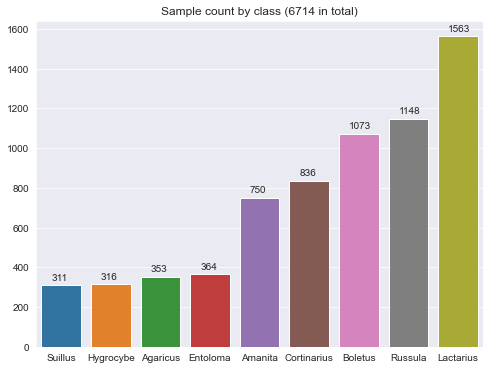

<IPython.core.display.Javascript object>

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

# Separate X and Y from the count dictionary
sorted_samples_per_specie = dict(sorted(samples_per_specie.items(), key=lambda x: x[1]))
keys = list(sorted_samples_per_specie.keys())
vals = list(sorted_samples_per_specie.values())

# Plot the counts
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=keys, y=vals)
for p in ax.patches:
    ax.annotate("{:.0f}".format(p.get_height()), (p.get_x() + 0.2, p.get_height() + 25))

n_of_samples = sum(vals)

plt.title(f"Sample count by class ({n_of_samples} in total)")
plt.show()

Judging by the graph and counts, the samples are very different between each class, for example, the are <b>5x</b> as many samples for the "Lactarius" class than there is for "Sulius". 

Since the dataset is imbalanced, this will most likely result in the model being more accurate in predicting some classes than others.  

### Visualizing each class

Next, I will plot 5 examples of each class to get an idea of the data

<Figure size 1440x1080 with 0 Axes>

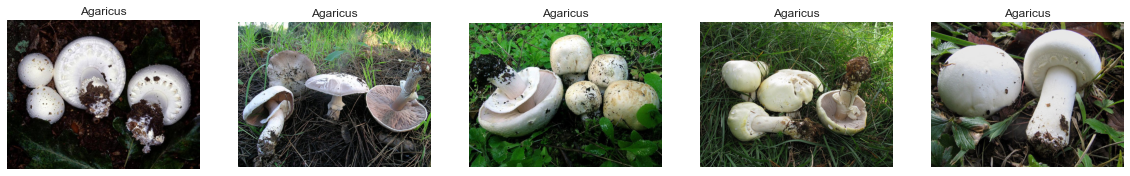

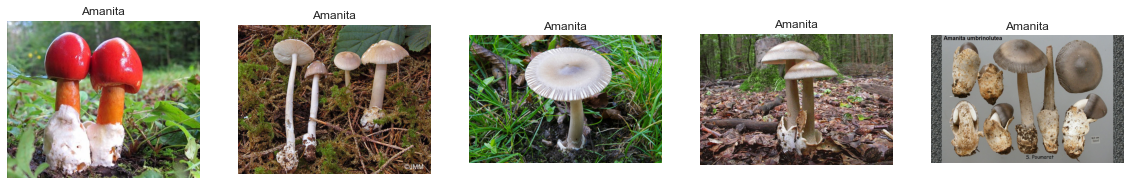

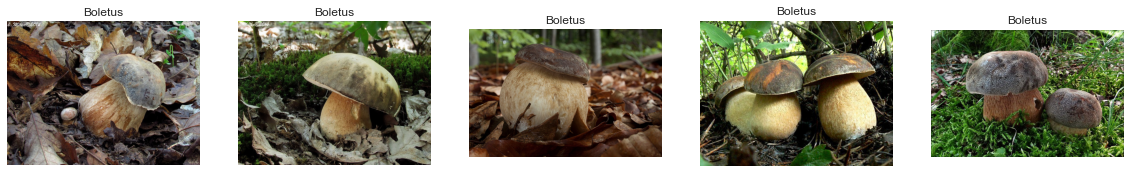

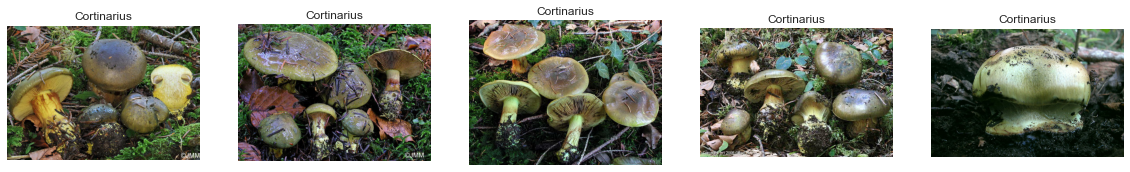

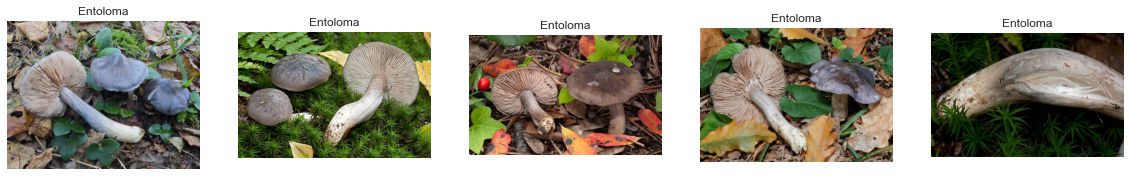

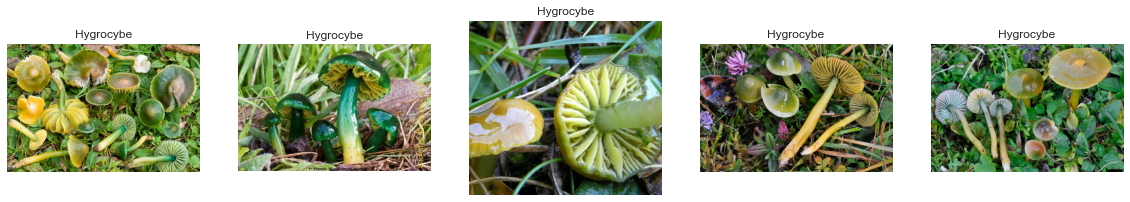

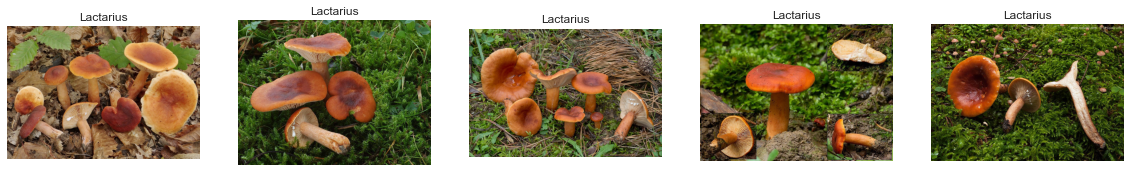

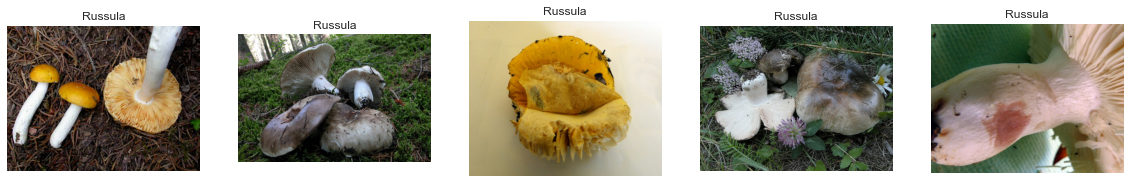

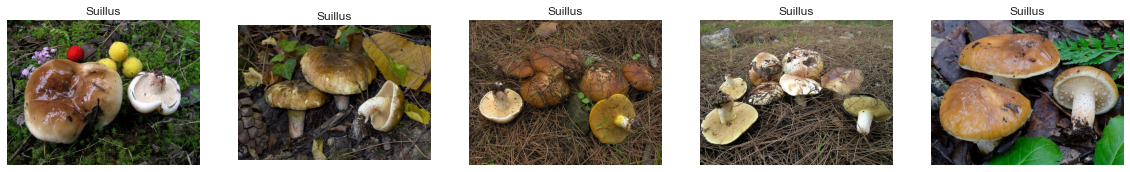

<IPython.core.display.Javascript object>

In [109]:
from PIL import Image

plt.figure(figsize=(20, 15))

# Iterate through every folder in the Mushroom directory
directory = os.listdir("Mushrooms")
for folder in directory:
    plt.figure(figsize=(20, 8))
    currentFolder = "Mushrooms/" + folder
    
    # Plot first 5 images
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = currentFolder + "/" + file
        img = np.asarray(Image.open(fullpath, "r"))
        plt.subplot(1, 5, i + 1)
        plt.axis("off")
        plt.grid(b=None)
        plt.title(folder)
        plt.imshow(img)

As we can see from the visualization, most of the pictures are pretty similar - they depict a mushroom on the forest floor, although other images display the mushrooms in other environments or just their cross-sections.

Thus, I will quickly look through the images to see if there are images that differ even more

### Visual outliers

Here is what I found:

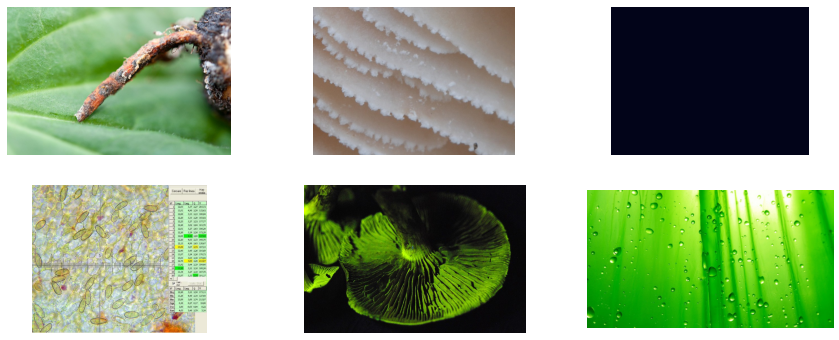

<IPython.core.display.Javascript object>

In [123]:
# Visual outliers

outliers = [
    "Mushrooms/Agaricus/249_moW6X1JYYoE.jpg",
    "Mushrooms/Amanita/438_gh-zSGziyQ4.jpg",
    "Mushrooms/Boletus/0051_rBIC-Uy9KzI.jpg",
    "Mushrooms/Boletus/0572_zdESww0j-to.jpg",
    "Mushrooms/Cortinarius/920_wzMtMlkv4bE.jpg",
    "Mushrooms/Russula/151_yX7oI-mM9hk.jpg",
]

plt.figure(figsize=(15, 6))
for i, file in enumerate(outliers):
    img = np.asarray(Image.open(file, "r"))
    plt.subplot(2, 3, i + 1)
    plt.axis("off")
    plt.grid(b=None)
    plt.imshow(img)

We can see from the given examples, that the dataset has not been checked for bad images - it contains images that do not display mushrooms. This will hurt prediction accuracy, especially for the classes with fewer samples.

## Creating a fastai model to predict mushroom spiecies

### Loading the data

In [4]:
# Clearing and setting path to dataset
path = Path()
path = Path("Mushrooms/")
path.ls()

(#9) [Path('Mushrooms/Agaricus'),Path('Mushrooms/Amanita'),Path('Mushrooms/Boletus'),Path('Mushrooms/Cortinarius'),Path('Mushrooms/Entoloma'),Path('Mushrooms/Hygrocybe'),Path('Mushrooms/Lactarius'),Path('Mushrooms/Russula'),Path('Mushrooms/Suillus')]

<IPython.core.display.Javascript object>

In [22]:
# Setting batch size. Since I am using a considerably fast gpu, I chose to use a larger batch size
bs = 32

<IPython.core.display.Javascript object>

In [6]:
# Specifying single image and batch transformations
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.0, 1.0))
batch_tfms = [
    *aug_transforms(size=224, max_warp=0),
    Normalize.from_stats(*imagenet_stats),
]

<IPython.core.display.Javascript object>

Next, I will initialize the data loader and set 30% of the data for validation

In [23]:
# Initializing image data loader and splitting dataset to training and validation sets
data = ImageDataLoaders.from_folder(
    path,
    train=".",
    valid_pct=0.3,
    size=224,
    bs=bs,
    seed=RANDOM_STATE,
    batch_tfms=batch_tfms,
    item_tfms=item_tfms,
)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


<IPython.core.display.Javascript object>

Windows and IPython does not allow cpu multiprocessing, although since I will mostly rely on my gpu, I left this error "as is"

In [8]:
# Confirming that dataloader recognized all of the classes
data.vocab

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']

<IPython.core.display.Javascript object>

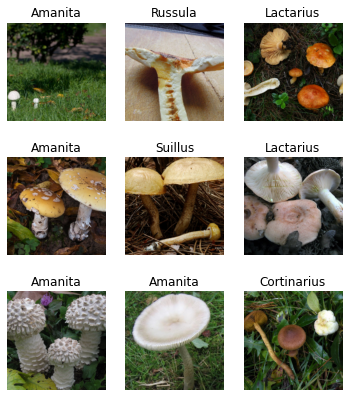

<IPython.core.display.Javascript object>

In [11]:
# Preview
data.show_batch(max_n=9, figsize=(6, 7))

In [9]:
# Confirming that the dataset has been split 70/30
len(data.train_ds), len(data.valid_ds)

(4700, 2014)

<IPython.core.display.Javascript object>

As we can see, the data loader is functional and the data is divided into training and validation sets. 

I would also like to make sure, that the distributions are similar after the split

In [168]:
valid_samples_per_specie = {}

# Iterating through every validation sample and counting the classes
for sample in data.valid_ds.items[:]:
    try:
        valid_samples_per_specie[str(sample).replace("\\", " ")[10:-20].strip()] += 1
    except:
        valid_samples_per_specie[str(sample).replace("\\", " ")[10:-20].strip()] = 1

valid_samples_per_specie

{'Hygrocybe': 104,
 'Agaricus': 109,
 'Boletus': 331,
 'Cortinarius': 258,
 'Lactarius': 474,
 'Entoloma': 103,
 'Russula': 332,
 'Amanita': 214,
 'Suillus': 89}

<IPython.core.display.Javascript object>

Once we have the counts for the validation set, I will continue with counting the distributions for the training set

In [171]:
train_samples_per_specie = {}

# Iterating through every validation sample and counting the classes
for sample in data.train_ds.items[:]:
    try:
        train_samples_per_specie[str(sample).replace("\\", " ")[10:-20].strip()] += 1
    except:
        train_samples_per_specie[str(sample).replace("\\", " ")[10:-20].strip()] = 1

train_samples_per_specie

{'Lactarius': 1089,
 'Boletus': 742,
 'Russula': 816,
 'Cortinarius': 578,
 'Agaricus': 244,
 'Amanita': 536,
 'Hygrocybe': 212,
 'Suillus': 222,
 'Entoloma': 261}

<IPython.core.display.Javascript object>

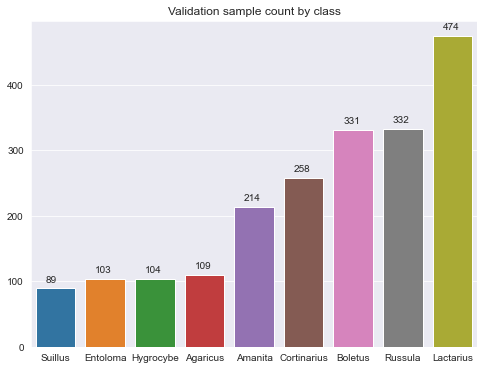

<IPython.core.display.Javascript object>

In [169]:
sorted_samples_per_specie = dict(
    sorted(valid_samples_per_specie.items(), key=lambda x: x[1])
)
keys = list(sorted_samples_per_specie.keys())
vals = list(sorted_samples_per_specie.values())

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=keys, y=vals)
for p in ax.patches:
    ax.annotate("{:.0f}".format(p.get_height()), (p.get_x() + 0.2, p.get_height() + 10))
plt.title("Validation sample count by class")
plt.show()

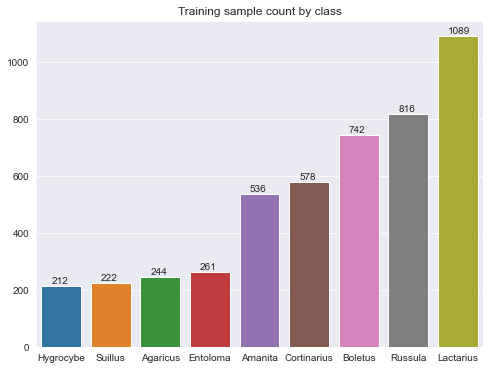

<IPython.core.display.Javascript object>

In [172]:
sorted_samples_per_specie = dict(
    sorted(train_samples_per_specie.items(), key=lambda x: x[1])
)
keys = list(sorted_samples_per_specie.keys())
vals = list(sorted_samples_per_specie.values())

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=keys, y=vals)
for p in ax.patches:
    ax.annotate("{:.0f}".format(p.get_height()), (p.get_x() + 0.2, p.get_height() + 10))
plt.title("Training sample count by class")
plt.show()

Comparing the validation and training set distributions, we can see that they are pretty similar, the sorted sequence is identical and the distributions seem comparable

### Model training

Now that we have the data successfully loaded to our data loader, we are only missing the actual model. For the backbone of our model, I will be using resnet50. For metrics, I specified accuracy since it seems to me to be the most relevant in this use case

In [265]:
# Loading up ResNet50
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

<IPython.core.display.Javascript object>

Since we are working with visual data, we can utilise GPUs that support Cuda

In [10]:
# Checking if PyTorch recognizes my GPU
import torch

torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080'

<IPython.core.display.Javascript object>

In [11]:
# Checking if my GPU is supported
print("torch.cuda.is_available():", torch.cuda.is_available())

torch.cuda.is_available(): True


<IPython.core.display.Javascript object>

In [14]:
# Some of the images seem to be truncated and raise an exception
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

<IPython.core.display.Javascript object>

In [267]:
# Training the last layer of ResNet50 for 8 epochs
learn.fit_one_cycle(8)

<IPython.core.display.Javascript object>

<i>I have tried training using only my CPU without multiprocessing, and one epoch took about 40 minutes, enabling multiprocessing reduced training time to about 10 minutes and finally, training one epoch on my GPU takes >2 minutes

As we can see, the model achieved an accuracy of ~86%, a training loss of ~0.19 and a validation loss of ~0.47, which indicates overfitting

Next, I will backup the model and try to estimate the optimal learning rate for fine-tuning

In [270]:
save_model(learn, "learn_after_8_epochs")

<IPython.core.display.Javascript object>

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=3.311311274956097e-06)

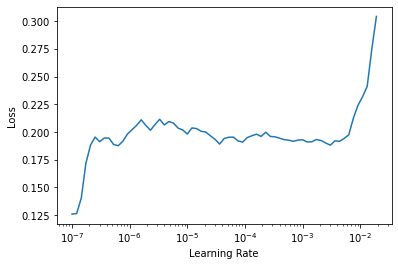

<IPython.core.display.Javascript object>

In [17]:
learn.lr_find()

Judging by the graph, it is hard to tell the optimal learning rate, although there does seem to be a drop around 10^(-5) and 10^(-4)

Next, I will unfreeze the whole network and train it 4 epochs with the new learning rate

In [271]:
# Fine-tuning
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(1e-5, 1e-4))

<IPython.core.display.Javascript object>

In [272]:
# Back-up model
save_model(learn, "learn")

<IPython.core.display.Javascript object>

After training the whole network for 4 epochs it achieved an accuracy of ~87%, a training loss of ~0.1 and a validation loss of ~0.41

## Model results

Now that we have a trained and fine-tuned model, we can further explore its accuracy with a confusion matrix and classification reports

In [49]:
my_learner = load_saved_model("learn")

# Calculating reports
interp = ClassificationInterpretation.from_learner(my_learner)

<IPython.core.display.Javascript object>

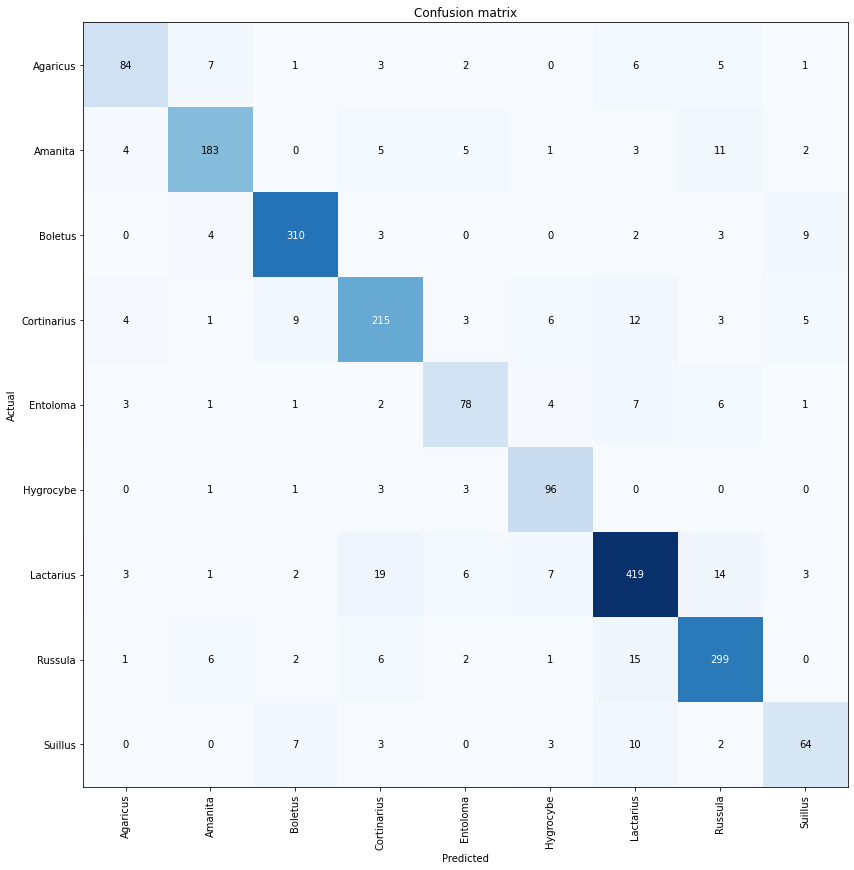

<IPython.core.display.Javascript object>

In [50]:
interp.plot_confusion_matrix(figsize=(12, 12))

As we can see from the confusion matrix, the network was correct with most of its predictions, although there does seem to also be plenty of mistakes.

Let us see if we can confirm this with a classification report.

In [275]:
interp.print_classification_report()

              precision    recall  f1-score   support

    Agaricus       0.85      0.77      0.81       109
     Amanita       0.90      0.86      0.88       214
     Boletus       0.93      0.94      0.93       331
 Cortinarius       0.83      0.83      0.83       258
    Entoloma       0.79      0.76      0.77       103
   Hygrocybe       0.81      0.92      0.86       104
   Lactarius       0.88      0.88      0.88       474
     Russula       0.87      0.90      0.89       332
     Suillus       0.75      0.72      0.74        89

    accuracy                           0.87      2014
   macro avg       0.85      0.84      0.84      2014
weighted avg       0.87      0.87      0.87      2014



<IPython.core.display.Javascript object>

The classification mostly confirms my hypothesis - the model is correct ~85% of all times, but the accuracy for each class varies from ~75% to ~93%

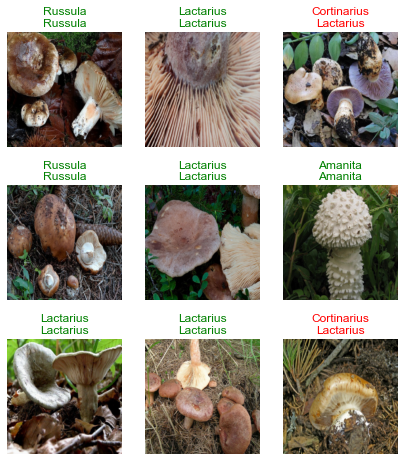

<IPython.core.display.Javascript object>

In [276]:
# Visualizing predictions
my_learner.show_results(max_n=9, figsize=(7, 8))

No new information from sample prediction, the model is great in most cases, although does have a bias to misclassify the "Lactarius" class as the "Cortinarius"

One last step for the network evaluation is calculating inference (prediction) time to see if the network would be viable for a production environment

In [58]:
%%time

# 10 predictions using the GPU:
for sample in range(10):
    my_learner.predict(data.valid_ds.items[sample])[0]

Wall time: 458 ms


<IPython.core.display.Javascript object>

In [59]:
# Setting the network to use the cpu
my_learner.dls.device = "cpu"

<IPython.core.display.Javascript object>

In [63]:
%%time

# 10 predictions using the CPU:
for sample in range(10):
    my_learner.predict(data.valid_ds.items[sample])[0]

Wall time: 1.93 s


<IPython.core.display.Javascript object>

In [65]:
# Setting the network back to use the gpu
my_learner.dls.device = "cuda"

<IPython.core.display.Javascript object>

As a rule of thumb, the inference times in a production environment should be below 100ms, so this network would be completely viable if the environment had access to a Cuda-enabled GPU, since, on my GPU, the inference for a single sample is <50ms, although if the production environment does not have a supported GPU or a significantly more powerful CPU, inference times could become a problem since in my case, the inference of a single sample on the CPU took ~200ms

### Conclusions

A simple ResNet50 neural network seems to be "good enough" for this problem, although it did seem to overfit and not generalise perfectly. Due to this reason, next, I would like to try a different optimizer and introduce l2 regularization

## Model with regularization

In [25]:
# Once again loading up ResNet50
learn_w_wd = cnn_learner(
    data, models.resnet50, metrics=accuracy, opt_func=partial(Adam, decouple_wd=False)
)

# Regularization
l2 = 0.001

<IPython.core.display.Javascript object>

In [26]:
# Training the last layer of ResNet50 for 8 epochs with weight dacay this time
learn_w_wd.fit_one_cycle(8, wd=l2)

<IPython.core.display.Javascript object>

As we recall, a network without regularization achieved an accuracy of ~86%, a training loss of ~0.19 and a validation loss of ~0.47, while this network with regularization achieved an accuracy of ~85%, a training loss of ~0.19 and a validation loss of ~0.44.

Very similar results so far, but we will need to confirm this

In [33]:
# Back-up trained model
save_model(learn_w_wd, "learn_w_wd_after_8_epochs.pkl")

<IPython.core.display.Javascript object>

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=5.754399353463668e-06)

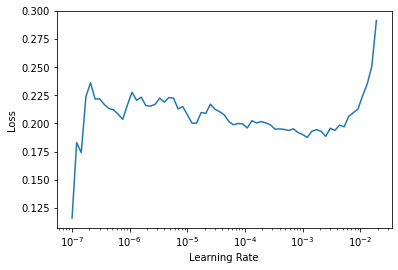

<IPython.core.display.Javascript object>

In [27]:
learn_w_wd.lr_find()

This time, the optimal learning rate is somewhere between 10^(-4) and 10^(-3)

In [28]:
# Fine-tuning
learn_w_wd.unfreeze()
learn_w_wd.fit_one_cycle(4, lr_max=slice(1e-4, 1e-3), wd=l2)

<IPython.core.display.Javascript object>

Similar, although slightly better results after fine-tuning: validation loss went down from ~0.41 to ~0.31 and accuracy increased from ~0.87 to ~0.90

In [29]:
save_model(learn_w_wd, "learn_w_wd")

<IPython.core.display.Javascript object>

## Model with regularization results

In [30]:
learner_w_wd = load_saved_model("learn_w_wd")

# Calculating reports
interp_w_wd = ClassificationInterpretation.from_learner(learner_w_wd)

<IPython.core.display.Javascript object>

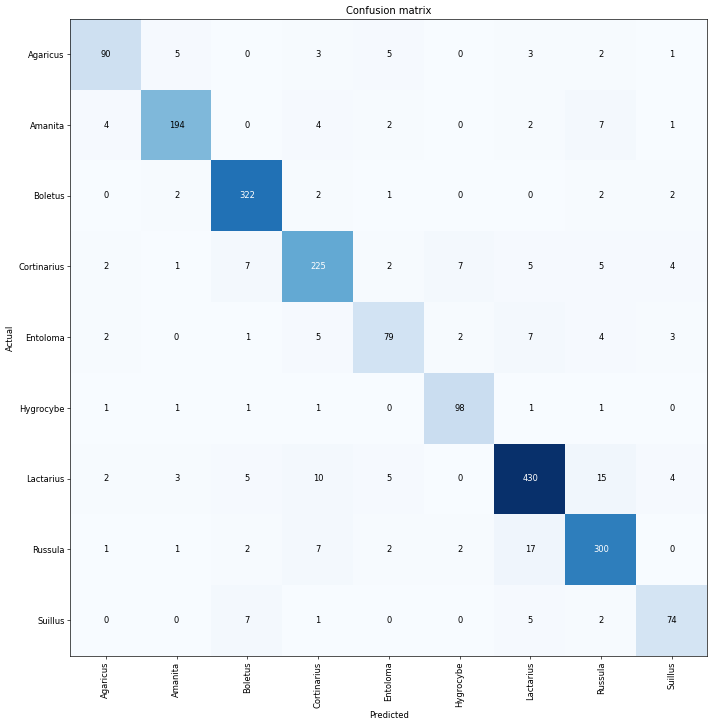

<IPython.core.display.Javascript object>

In [31]:
interp_w_wd.plot_confusion_matrix(figsize=(12, 12), dpi=60)

As we can see from the confusion matrix, this time, the network with regularization seems to be at least as accurate, but we will need to confirm this with a classification report

In [32]:
interp_w_wd.print_classification_report()

              precision    recall  f1-score   support

    Agaricus       0.88      0.83      0.85       109
     Amanita       0.94      0.91      0.92       214
     Boletus       0.93      0.97      0.95       331
 Cortinarius       0.87      0.87      0.87       258
    Entoloma       0.82      0.77      0.79       103
   Hygrocybe       0.90      0.94      0.92       104
   Lactarius       0.91      0.91      0.91       474
     Russula       0.89      0.90      0.90       332
     Suillus       0.83      0.83      0.83        89

    accuracy                           0.90      2014
   macro avg       0.89      0.88      0.88      2014
weighted avg       0.90      0.90      0.90      2014



<IPython.core.display.Javascript object>

As we can see, on average, the model is accurate ~90% of the time, whereas the previous model had a slightly lower accuracy of ~87%. Also, the variance in accuracy between classes is lower - the lowest accuracy for this new model is ~82% (the previous model achieved ~75% accuracy)

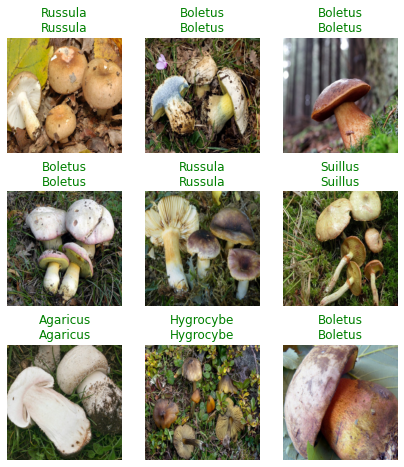

<IPython.core.display.Javascript object>

In [61]:
learner_w_wd.show_results(max_n=9, figsize=(7, 8))

As expected, the model is accurate most of the time. Since fastai provides us with a method to view samples with the highest loss, maybe that will help us understand where the model struggled

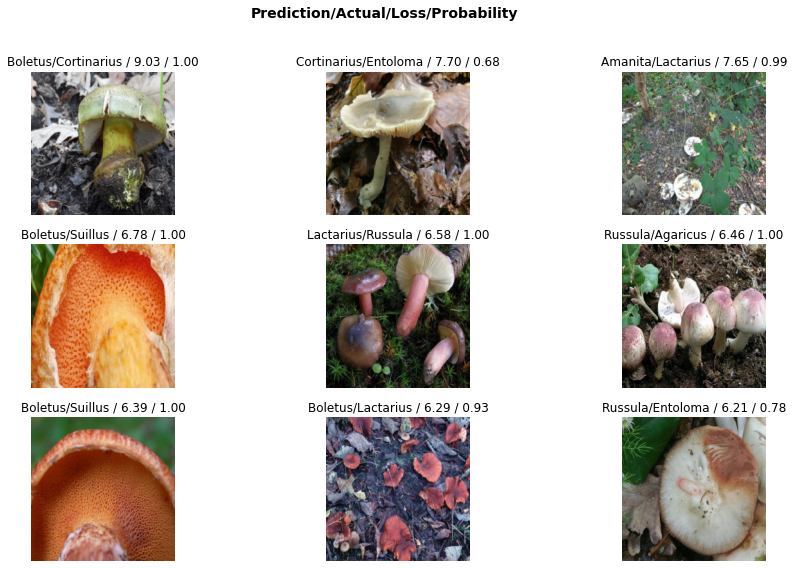

<IPython.core.display.Javascript object>

In [34]:
SegmentationInterpretation.from_learner(learner_w_wd).plot_top_losses(
    k=9, figsize=(15, 9)
)

Most of the results are expected - misclassified mushrooms, although two  images are of the underside of the mushroom, not of the whole mushroom and could be considered outliers. Also, in two of the pictures it is difficult to even find mushrooms

Once again, last step for the network evaluation is calculating inference (prediction) time to see if the network would be viable for a production environment

In [68]:
%%time

# 10 predictions using the GPU:
for sample in range(10):
    learner_w_wd.predict(data.valid_ds.items[sample])[0]

Wall time: 473 ms


<IPython.core.display.Javascript object>

In [69]:
# Setting the network to use the cpu
learner_w_wd.dls.device = "cpu"

<IPython.core.display.Javascript object>

In [71]:
%%time

# 10 predictions using the CPU:
for sample in range(10):
    learner_w_wd.predict(data.valid_ds.items[sample])[0]

Wall time: 1.94 s


<IPython.core.display.Javascript object>

In [72]:
# Setting the network back to use the gpu
learner_w_wd.dls.device = "cuda"

<IPython.core.display.Javascript object>

Since this network is of very similar complexity, the inference times for a single item it achieved are mostly the same - <50ms on the GPU and ~200ms on the CPU. As I stated with the previous model, if the production environment does not have a supported GPU or a significantly more powerful CPU, inference times could become a problem

### Conclusions

ResNet50 with regularization performed slightly better than a network without it and achieved an average accuracy of ~90%, with a minimum class accuracy of ~82%. 

I believe this would be "good enough" for a production environment, especially if the environment has access to a Cuda-enabled GPU, but there is still room for improvement

### Ideas for future improvements

* <b>Data augmentation</b> - 6 out of 9 classes have less than 1000 samples, thus, increasing the size of the dataset with data augmentation would most likely significantly improve the accuracy
* <b>Cleaning original dataset</b> - as we have seen from EDA, the dataset contains irregular samples or even unrelated pictures. Removing these would also likely improve accuracy
* <b>Simpler backbone network</b> - this time I chose to use ResNet50, although there are simpler networks that could achieve similar results, which would improve training and inference times